In [1]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt

In [2]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import function_gradient_Hessian as model

# load data

In [3]:
data = np.load('simulation_data.npy')
latent = np.load('simulation_latent.npy')

In [4]:
data.shape, latent.shape

((10, 20, 20), (10, 20))

# parameters

In [5]:
l_penalty = 0.02
step_size = 0.005
max_iter = 50000
ths = 1e-9

# operators

In [6]:
def objective_l2(beta, game_matrix_list, l_penalty):
    '''
    compute the objective of the model
    ----------
    Input:
    beta: TxN array or a TN vector
    game_matrix_list: TxNxN array
    ----------
    Output:
    objective: negative log likelihood + l2 penalty
    '''
    # reshape beta into TxN array
    T, N = game_matrix_list.shape[0:2]
    beta = np.reshape(beta, [T,N])
    
    # compute l2 penalty
    l2_penalty = np.sum(np.square(beta[:-1]-beta[1:]))
    
    return model.loglike(beta, game_matrix_list) + l_penalty * l2_penalty

In [7]:
def prox_l2(beta, s, l):
    '''
    proximal operator for l2-penalty
    '''
    n = np.array(beta).shape[0]
    
    # define banded matrix
    banded = np.block([
        [np.zeros([1,1]), (-1)*s*l*np.ones([1,n-1])],
        [(1+s*l)*np.ones([1,1]), (1+2*s*l)*np.ones([1,n-2]), (1+s*l)*np.ones([1,1])],
        [(-1)*s*l*np.ones([1,n-1]), np.zeros([1,1])]
    ])
    
    # solve banded @ beta* = beta
    return spl.solve_banded((1,1), banded, beta, True, True, False)

# PGD without backtracking line search

In [9]:
# intiialize optimization
T, N = data.shape[0:2]
beta = np.zeros(data.shape[:2])

# initialize record
objective_values = [objective_l2(beta, data, l_penalty)]
print("initial objective value: %f"%objective_values[-1])

# iteration
for i in range(max_iter):
    # compute gradient
    gradient = model.grad_l(beta, data).reshape([T,N])
    
    # proximal gradient update
    beta = prox_l2(beta - step_size*gradient, step_size, l_penalty)
    
    # objective value
    objective_values.append(objective_l2(beta, data, l_penalty))
    
    print("%d-th PGD, objective value: %f"%(i+1, objective_values[-1]))
    if objective_values[-2] - objective_values[-1] < ths:
        print("Converged!")
        break
        
if i >= max_iter:
    print("Not converged.")

initial objective value: 13028.394406
1-th PGD, objective value: 12131.439186
2-th PGD, objective value: 11603.932674
3-th PGD, objective value: 11279.933948
4-th PGD, objective value: 11071.268152
5-th PGD, objective value: 10931.148572
6-th PGD, objective value: 10833.724270
7-th PGD, objective value: 10764.010656
8-th PGD, objective value: 10712.922191
9-th PGD, objective value: 10674.727409
10-th PGD, objective value: 10645.684736
11-th PGD, objective value: 10623.278518
12-th PGD, objective value: 10605.773740
13-th PGD, objective value: 10591.947070
14-th PGD, objective value: 10580.919186
15-th PGD, objective value: 10572.047264
16-th PGD, objective value: 10564.854307
17-th PGD, objective value: 10558.981643
18-th PGD, objective value: 10554.156360
19-th PGD, objective value: 10550.168579
20-th PGD, objective value: 10546.855333
21-th PGD, objective value: 10544.088972
22-th PGD, objective value: 10541.768709
23-th PGD, objective value: 10539.814380
24-th PGD, objective value: 

/home/hbong/miniconda3/envs/sklearnprod0/lib/python3.6/site-packages/ipykernel/__main__.py:15: DeprecationWarning: Use of the "debug" keyword is deprecated and this keyword will be removed in the future versions of SciPy.


48-th PGD, objective value: 10528.251873
49-th PGD, objective value: 10528.197156
50-th PGD, objective value: 10528.148484
51-th PGD, objective value: 10528.105150
52-th PGD, objective value: 10528.066538
53-th PGD, objective value: 10528.032105
54-th PGD, objective value: 10528.001377
55-th PGD, objective value: 10527.973935
56-th PGD, objective value: 10527.949412
57-th PGD, objective value: 10527.927484
58-th PGD, objective value: 10527.907864
59-th PGD, objective value: 10527.890300
60-th PGD, objective value: 10527.874568
61-th PGD, objective value: 10527.860470
62-th PGD, objective value: 10527.847830
63-th PGD, objective value: 10527.836493
64-th PGD, objective value: 10527.826320
65-th PGD, objective value: 10527.817188
66-th PGD, objective value: 10527.808987
67-th PGD, objective value: 10527.801621
68-th PGD, objective value: 10527.795003
69-th PGD, objective value: 10527.789054
70-th PGD, objective value: 10527.783706
71-th PGD, objective value: 10527.778897
72-th PGD, objec

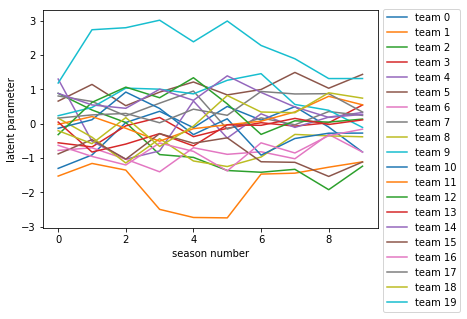

In [12]:
for i in range(N):
    plt.plot(beta[:,i], label="team %d"%i)
plt.xlabel("season number")
plt.ylabel("latent parameter")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.03, 1, 0))